In [4]:
# This versions shpuld work fine

!pip install scipy==1.0.1
!pip install tensorflow==1.15.0 --force-reinstall


  Using cached https://files.pythonhosted.org/packages/3f/98/5a99af92fb911d7a88a0005ad55005f35b4c1ba8d75fba02df726cd936e6/tensorflow-1.15.0-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/28/05/9867ef8eafd12265267bee138fa2c46ebf34a276ea4cbe184cba4c606e8b/protobuf-3.12.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/de/62/2ee9cd74c9fa2fa450877847ba560b260f5d0fb70ee0595203082dafcc9d/tensorflow_estimator-1.15.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b3/a9/b1bc4c935ed063766bce7d3e8c7b20bd52e515ff1c732b02caacf7918e5a/numpy-1.18.5-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/79/4c/7c3275a01e12ef9368a892926ab932b33bb13d55794881e3573482b378a7/Keras_Preprocessing-1.1.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a3/de/c648ef6835192e6e2cc03f40b19eeda4382c49b5bafb43d88b931c4c74ac/google_pasta-0.2.0-py3-

In [5]:
from __future__ import print_function, division
from IPython.core import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# if you're running in colab
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_RL/0ccb0673965dd650d9b284e1ec90c2bfd82c8a94/week08_pomdp/atari_util.py
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_RL/0ccb0673965dd650d9b284e1ec90c2bfd82c8a94/week08_pomdp/env_pool.py

# If you are running on a server, launch xvfb to record game videos
# Please make sure you have xvfb installed
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

--2020-06-17 23:15:26--  https://raw.githubusercontent.com/yandexdataschool/Practical_RL/0ccb0673965dd650d9b284e1ec90c2bfd82c8a94/week08_pomdp/atari_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2271 (2.2K) [text/plain]
Saving to: ‘atari_util.py.1’

atari_util.py.1     100%[===================>]   2.22K  --.-KB/s    in 0s      

2020-06-17 23:15:26 (40.2 MB/s) - ‘atari_util.py.1’ saved [2271/2271]

--2020-06-17 23:15:27--  https://raw.githubusercontent.com/yandexdataschool/Practical_RL/0ccb0673965dd650d9b284e1ec90c2bfd82c8a94/week08_pomdp/env_pool.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443.

### KungFuMaster env

In [6]:
import gym
from atari_util import PreprocessAtari


def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = PreprocessAtari(env, height=42, width=42,
                          crop=lambda img: img[60:-30, 15:],
                          color=False, n_frames=1)
    return env


env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (1, 42, 42)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


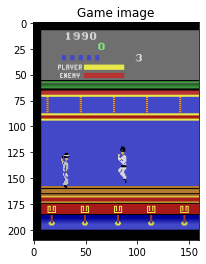

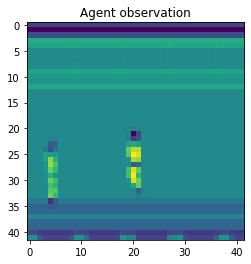

In [7]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation')
plt.imshow(s.reshape([42,42]))
plt.show()

### Simple agent for fully-observable MDP

Here's a code for an agent that only uses feedforward layers. Please read it carefully: you'll have to extend it later!

In [8]:
# # http://pytorch.org/
# from os import path
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

# accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
# import torch

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [10]:
class FeedforwardAgent(nn.Module):
    def __init__(self, obs_shape, n_actions):
        """A simple actor-critic agent"""
        super(self.__class__, self).__init__()
        
        # Note: number of units/filters is arbitrary, you can and should change it at your will
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), stride=(2,2))
        self.conv1 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=(2,2))
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=(2,2))
        self.flatten = Flatten()
        
        self.hid = nn.Linear(512, 128)
        self.logits = nn.Linear(128, n_actions)
        self.state_value = nn.Linear(128, 1)
            
        
    def forward(self, prev_state, obs_t):
        """
        Takes agent's previous step and observation (np.array), 
        returns next state and whatever it needs to learn (torch variables)
        """        
        nn = F.elu(self.conv0(obs_t))
        nn = F.elu(self.conv1(nn))
        nn = F.elu(self.conv2(nn))
        nn = self.flatten(nn)
        nn = F.elu(self.hid(nn))
        logits = self.logits(nn)
        state_value = self.state_value(nn)[:,0]
        
        # feedforward agent has no state
        new_state = []
        
        return new_state, (logits, state_value)
    
    def get_initial_state(self, batch_size):
        """
        Return a list of agent memory states at game start (Variables).
        Each state is a np array of shape [batch_size, ...]
        """
        # feedforward agent has no state
        return []
            
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        probs = F.softmax(logits)
        return torch.multinomial(probs, 1)[:, 0].data.numpy()
    
    def step(self, prev_state, obs_t):
        """ like forward, but obs_t is not Variable """
        obs_t = Variable(torch.FloatTensor(np.array(obs_t)))
        return self.forward(prev_state, obs_t)

In [11]:
n_parallel_games = 5
gamma = 0.99

agent = FeedforwardAgent(obs_shape, n_actions)

In [12]:
state = [env.reset()]
_, (logits, value) = agent.step(agent.get_initial_state(1), state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 tensor([[-0.0816,  0.0955,  0.0904, -0.1005,  0.0631,  0.0418,  0.0815, -0.0731,
         -0.0941, -0.0922,  0.1337, -0.0676, -0.0184,  0.0156]],
       grad_fn=<AddmmBackward>)
state values:
 tensor([-0.0616], grad_fn=<SelectBackward>)


### Let's play!
Let's build a function that measures agent's average reward.

In [13]:
def evaluate(agent, env, n_games=1):
    """Plays an entire game start to end, returns session rewards."""

    game_rewards = []
    for _ in range(n_games):
        # initial observation and memory
        observation = env.reset()
        prev_memories = agent.get_initial_state(1)

        total_reward = 0
        while True:
            new_memories, readouts = agent.step(prev_memories, observation[None, ...])
            action = agent.sample_actions(readouts)

            observation, reward, done, info = env.step(action[0])

            total_reward += reward
            prev_memories = new_memories
            if done: break
                
        game_rewards.append(total_reward)
    return game_rewards


In [14]:
# !apt install libav-tools

In [15]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
rw = evaluate(agent, env_monitor, n_games=3,)
env_monitor.close()
print (rw)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1000.0, 1300.0, 600.0]


In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

### Training on parallel games

We introduce a class called EnvPool - it's a tool that handles multiple environments for you. Here's how it works:
![img](https://s7.postimg.org/4y36s2b2z/env_pool.png)

In [16]:
from env_pool import EnvPool
pool = EnvPool(agent, make_env, n_parallel_games)

In [18]:
# for each of n_parallel_games, take 10 steps
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [19]:
print("Actions shape:", rollout_actions.shape)
print("Rewards shape:", rollout_rewards.shape)
print("Mask shape:", rollout_mask.shape)
print("Observations shape: ",rollout_obs.shape)

Actions shape: (5, 10)
Rewards shape: (5, 10)
Mask shape: (5, 10)
Observations shape:  (5, 10, 1, 42, 42)


# Actor-critic

Here we define a loss function that uses rollout above to train

In [23]:
def to_one_hot(y, n_dims=None):
    """ Take an integer vector (tensor of variable) and convert it to 1-hot matrix. """
    y_tensor = y.data if isinstance(y, Variable) else y
    y_tensor = y_tensor.type(torch.LongTensor).reshape(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    return Variable(y_one_hot) if isinstance(y, Variable) else y_one_hot

In [44]:
opt = torch.optim.Adam(agent.parameters(), lr=1e-5)

def train_on_rollout(states, actions, rewards, is_not_done, prev_memory_states, gamma = 0.99):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """
    
    # cast everything into a variable
    states = Variable(torch.FloatTensor(np.array(states)))   # shape: [batch_size, time, c, h, w]
    actions = Variable(torch.IntTensor(np.array(actions)))   # shape: [batch_size, time]
    rewards = Variable(torch.FloatTensor(np.array(rewards))) # shape: [batch_size, time]
    is_not_done = Variable(torch.FloatTensor(is_not_done.astype('float32')))  # shape: [batch_size, time]
    rollout_length = rewards.shape[1] - 1
    

    # predict logits, probas and log-probas using an agent. 
    memory = [m.detach() for m in prev_memory_states]
    
    logits = [] # append logit sequence here
    state_values = [] #append state values here
    for t in range(rewards.shape[1]):
        obs_t = states[:, t]
        
        # use agent to comute logits_t and state values_t.
        # append them to logits and state_values array
        
        memory, (logits_t, state_v_t) = agent.forward(memory, obs_t)
        logits.append(logits_t)
        state_values.append(state_v_t)
        
        
    logits = torch.stack(logits, dim=1)
    state_values = torch.stack(state_values, dim=1)
    
    probas = F.softmax(logits, -1)
    logprobas = F.log_softmax(logits, -1)
        
    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    actions_one_hot = to_one_hot(actions, n_actions).view(actions.shape[0], actions.shape[1], n_actions)
    logprobas_for_actions = torch.sum(logprobas * actions_one_hot,
                                      dim = -1)    
    # Policy gradient objective. 
    # Notes: Please don't forget to call .detach() on advantage term. Also please use mean, not sum.
    # it's okay to use loops if you want
    J_hat = 0 # policy objective as in the formula for J_hat
    
    # Temporal difference MSE for state values
    # Notes: Please don't forget to call on V(s') term. Also please use mean, not sum.
    # it's okay to use loops if you want
    TD_loss = 0

    
    for t in range(rollout_length):
        v_t = state_values[:, t]
        v_t_next = state_values[:, t + 1].detach()
        r = rewards[:, t]
        
        mask = is_not_done[:, t]
        td_loss_t = torch.mean((r + gamma * mask * v_t_next - v_t) ** 2)
        
        advantage = r + gamma * mask * v_t_next - v_t
        advantage = advantage.detach()
        logp_for_actions_t = logprobas_for_actions[:, t]
        j_hat_t = torch.mean(logp_for_actions_t * advantage)

        
        # compute TD_loss and J_hat for moment  
        J_hat += j_hat_t
        TD_loss += td_loss_t
    #print(len(J_hat))

    J_hat = J_hat/rollout_length
    TD_loss = TD_loss/rollout_length
    
    #regularize with entropy
    entropy_reg = -torch.mean(torch.sum(probas * logprobas, dim=-1)) #<compute mean entropy of probas. Don't forget the sign!>
    
    loss = - J_hat - 0.05 * entropy_reg + TD_loss
    
    # Gradient descent step
    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), 90)
    opt.step()
    opt.zero_grad()
    
    return loss.data.numpy(), grad_norm, entropy_reg.data.numpy()

In [45]:
# let's test it
memory = list(pool.prev_memory_states)
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)

train_on_rollout(rollout_obs, rollout_actions, rollout_rewards, rollout_mask, memory)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(array(-0.13007419, dtype=float32),
 tensor(0.0070),
 array(2.6359112, dtype=float32))

# Train 

just run train step and see if agent learns any better

In [46]:
# !pip install tqdm

In [47]:
from IPython.display import clear_output
from tqdm import trange
from pandas import ewma
rewards_history = []

ImportError: ignored

In [60]:
from IPython.display import clear_output
from tqdm import trange
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

rewards_history = []
grad_norm_history = []
entropy_history = []
loss_history = []

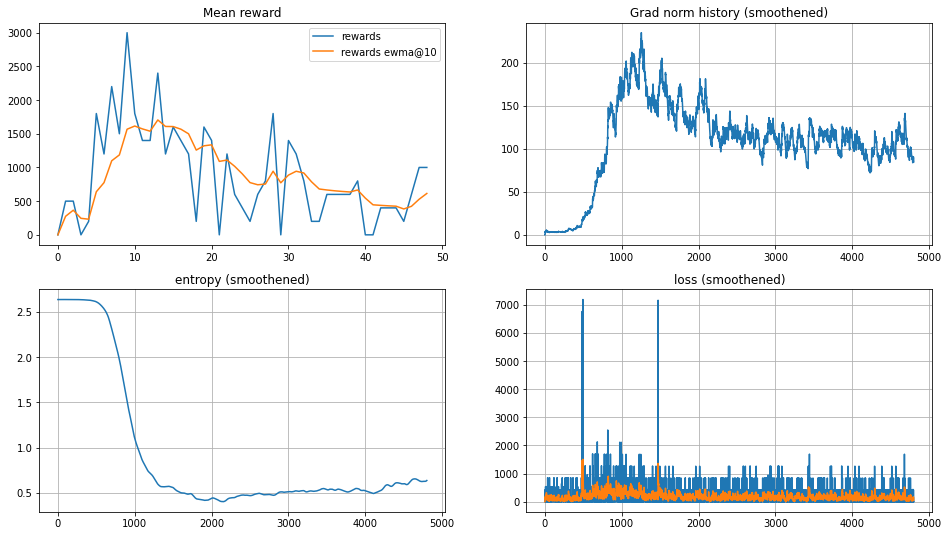

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: ignored

In [49]:
for i in range(0, 10000):

    memory = list(pool.prev_memory_states)
    rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(
        20)
    loss, grad_norm, entropy = train_on_rollout(rollout_obs, rollout_actions,
                     rollout_rewards, rollout_mask, memory)
    grad_norm_history.append(grad_norm)
    entropy_history.append(entropy)
    loss_history.append(loss)
    if i % 100 == 0:
        rewards_history.append(np.mean(evaluate(agent, env, n_games=1)))
        clear_output(True)
        
        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Mean reward")
        plt.plot(rewards_history, label='rewards')
        plt.plot(moving_average(np.array(rewards_history),
                                span=10), label='rewards ewma@10')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.title("Grad norm history (smoothened)")
        plt.plot(moving_average(np.array(grad_norm_history), span=100), label='grad norm ewma@100')
        plt.grid()
        
        plt.subplot(2, 2, 3)
        plt.title("entropy (smoothened)")
        plt.plot(moving_average(np.array(entropy_history), span=100), label='entropy ewma@100')
        plt.grid()
        
        plt.subplot(2, 2, 4)
        plt.title("loss (smoothened)")
        plt.plot(np.array(loss_history), label='loss raw')
        plt.plot(moving_average(np.array(loss_history), span=10), label='loss ewma@10')
        plt.grid()


        plt.show()
        
        if rewards_history[-1] >= 10000:
            print("Your agent has just passed the minimum homework threshold")
            break


In [ ]:
# for i in trange(5000):  
    
#     memory = list(pool.prev_memory_states)
#     rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)
#     train_on_rollout(rollout_obs, rollout_actions, rollout_rewards / 100, rollout_mask, memory)    
    
#     if i % 100 == 0: 
#         rewards_history.append(np.mean(evaluate(agent, env, n_games=1)))
#         clear_output(True)
#         plt.plot(rewards_history, label='rewards')
#         plt.plot(ewma(np.array(rewards_history),span=10), label='rewards ewma@10')
#         plt.legend()
#         plt.show()
#         if rewards_history[-1] >= 10000:
#             print("Your agent has just passed the minimum homework threshold")
#             break

### "Final" evaluation

In [ ]:
# env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
# final_rewards = evaluate(agent, env_monitor, n_games=20,)
# env_monitor.close()
# print("Final mean reward:", np.mean(final_rewards))

# video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))
# HTML("""
# <video width="640" height="480" controls>
#   <source src="{}" type="video/mp4">
# </video>
# """.format("./kungfu_videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

In [ ]:
!ls kungfu_videos


# from google.colab import files

# print("kungfu_videos/" + video_names[-3])
# files.download("kungfu_videos/" + video_names[-3])

openaigym.episode_batch.0.2817.stats.json
openaigym.manifest.0.2817.manifest.json
openaigym.video.0.2817.video000000.meta.json
openaigym.video.0.2817.video000000.mp4
openaigym.video.0.2817.video000001.meta.json
openaigym.video.0.2817.video000001.mp4


### POMDP setting

The atari game we're working with is actually a POMDP: your agent needs to know timing at which enemies spawn and move, but cannot do so unless it has some memory. 

Let's design another agent that has a recurrent neural net memory to solve this.

__Note:__ it's also a good idea to scale rollout_len up to learn longer sequences. You may wish set it to >=20 or to start at 10 and then scale up as time passes.

In [50]:
class SimpleRecurrentAgent(nn.Module):
    def __init__(self, obs_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        super(self.__class__, self).__init__()
        
        
        # Note: number of units/filters is arbitrary, you can and should change it at your will
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), stride=(2,2))
        self.conv1 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=(2,2))
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=(2,2))
        self.flatten = Flatten()
        
        self.hid = nn.Linear(512, 128)
        self.rnn = nn.LSTMCell(128, 128)
        self.logits = nn.Linear(128, n_actions)
        self.state_value = nn.Linear(128, 1)
            
        
    def forward(self, prev_state, obs_t):
        """
        Takes agent's previous step and observation (np.array), 
        returns next state and whatever it needs to learn (torch variables)
        """        
        nn = F.elu(self.conv0(obs_t))
        nn = F.elu(self.conv1(nn))
        nn = F.elu(self.conv2(nn))
        nn = self.flatten(nn)
        nn = F.elu(self.hid(nn))
        
        (next_h, next_c) = self.rnn(nn, prev_state)
        
        logits = self.logits(next_h)
        state_value = self.state_value(next_h)[:,0]
        
        return (next_h, next_c), (logits, state_value)
    
    def get_initial_state(self, batch_size):
        """Return a list of agent memory states at game start. Each state is a np array of shape [batch_size, ...]"""
        return Variable(torch.zeros(batch_size, 128)), Variable(torch.zeros(batch_size, 128))

    
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        probs = F.softmax(logits)
        return torch.multinomial(probs, 1)[:, 0].data.numpy()
    
    def step(self, prev_state, obs_t):
        """ like forward, but obs_t is not Variable """
        obs_t = Variable(torch.FloatTensor(np.array(obs_t)))
        (a, b), c = self.forward(prev_state, obs_t)
        return (a.detach(), b.detach()), c

In [61]:
agent = SimpleRecurrentAgent(obs_shape, n_actions)

### Now let's train it!

In [ ]:
### A whole lot of your code here: train the new agent with GRU memory.
# - create pool
# - write loss functions and training op
# - train
# You can reuse most of the code with zero to few changes

In [52]:
n_parallel_games = 5
from env_pool import EnvPool
pool = EnvPool(agent, make_env, n_parallel_games)

In [59]:
opt = torch.optim.SGD(agent.parameters(), lr=1e-5)

def train_on_rollout(states, actions, rewards, is_not_done, prev_memory_states, gamma = 0.99):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """
    
    # cast everything into a variable
    states = Variable(torch.FloatTensor(np.array(states)))   # shape: [batch_size, time, c, h, w]
    actions = Variable(torch.IntTensor(np.array(actions)))   # shape: [batch_size, time]
    rewards = Variable(torch.FloatTensor(np.array(rewards))) # shape: [batch_size, time]
    is_not_done = Variable(torch.FloatTensor(is_not_done.astype('float32')))  # shape: [batch_size, time]


    # predict logits, probas and log-probas using an agent. 
    memory = [m.detach() for m in prev_memory_states]
    
    logits = [] # append logit sequence here
    state_values = [] #append state values here
    for t in range(rewards.shape[1]):
        obs_t = states[:, t]
        
        # use agent to comute logits_t and state values_t.
        # append them to logits and state_values array
        
        memory, (logits_t, state_v_t) = agent.forward(memory, obs_t)
        logits.append(logits_t)
        state_values.append(state_v_t)
        
        
    logits = torch.stack(logits, dim=1)
    state_values = torch.stack(state_values, dim=1)
    
    probas = F.softmax(logits, -1)
    logprobas = F.log_softmax(logits, -1)
        
    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    actions_one_hot = to_one_hot(actions, n_actions).view(actions.shape[0], actions.shape[1], n_actions)
    logprobas_for_actions = torch.sum(logprobas * actions_one_hot,
                                      dim = -1)    
    # Policy gradient objective. 
    # Notes: Please don't forget to call .detach() on advantage term. Also please use mean, not sum.
    # it's okay to use loops if you want
    J_hat = 0 # policy objective as in the formula for J_hat
    
    # Temporal difference MSE for state values
    # Notes: Please don't forget to call on V(s') term. Also please use mean, not sum.
    # it's okay to use loops if you want
    TD_loss = 0
    
    for t in range(rewards.shape[1] - 1):
        v_t = state_values[:, t]
        v_t_next = state_values[:, t + 1].detach()
        r = rewards[:, t]
        
        mask = is_not_done[:, t]
        td_loss_t = torch.mean((r + gamma * mask * v_t_next - v_t) ** 2)
        
        advantage = r + gamma * mask * v_t_next - v_t
        advantage = advantage.detach()
        logp_for_actions_t = logprobas_for_actions[:, t]
        j_hat_t = torch.mean(logp_for_actions_t * advantage)

        
        # compute TD_loss and J_hat for moment  
        J_hat += j_hat_t
        TD_loss += td_loss_t
        
    J_hat = J_hat/(rewards.shape[1] - 1)
    TD_loss = TD_loss/(rewards.shape[1] - 1)
    
    #regularize with entropy
    entropy_reg = -torch.mean(torch.sum(probas * logprobas, dim=-1)) #<compute mean entropy of probas. Don't forget the sign!>
    
    loss = - J_hat - 0.01 * entropy_reg + TD_loss
    
    # Gradient descent step
    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), 90)
    opt.step()
    opt.zero_grad()
    
    return loss.data.numpy(), grad_norm, entropy_reg.data.numpy()

In [57]:
memory = list(pool.prev_memory_states)
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(20)
train_on_rollout(rollout_obs, rollout_actions, rollout_rewards, rollout_mask, memory) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(array(-0.02568692, dtype=float32),
 tensor(0.0007),
 array(2.6369238, dtype=float32))

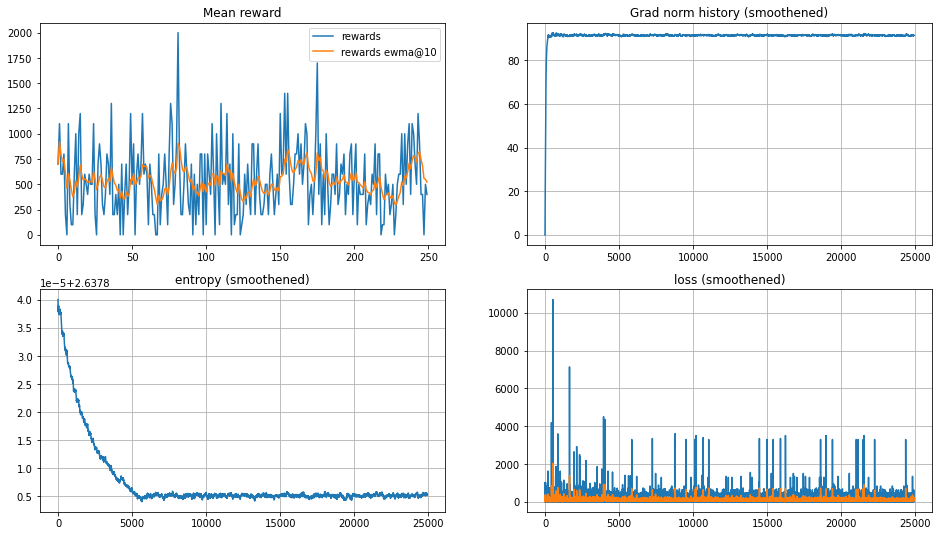

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [62]:
rollout_len = 10

for i in range(0, 25000):

    memory = list(pool.prev_memory_states)
    rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(rollout_len)
    loss, grad_norm, entropy = train_on_rollout(rollout_obs, rollout_actions,
                     rollout_rewards, rollout_mask, memory)
    grad_norm_history.append(grad_norm)
    entropy_history.append(entropy)
    loss_history.append(loss)

    if i % 200 == 0:
        rollout_len = min(40, rollout_len + 1)


    if i % 100 == 0:
        rewards_history.append(np.mean(evaluate(agent, env, n_games=1)))
        clear_output(True)
        
        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Mean reward")
        plt.plot(rewards_history, label='rewards')
        plt.plot(moving_average(np.array(rewards_history),
                                span=10), label='rewards ewma@10')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.title("Grad norm history (smoothened)")
        plt.plot(moving_average(np.array(grad_norm_history), span=100), label='grad norm ewma@100')
        plt.grid()
        
        plt.subplot(2, 2, 3)
        plt.title("entropy (smoothened)")
        plt.plot(moving_average(np.array(entropy_history), span=100), label='entropy ewma@100')
        plt.grid()
        
        plt.subplot(2, 2, 4)
        plt.title("loss (smoothened)")
        plt.plot(np.array(loss_history), label='loss raw')
        plt.plot(moving_average(np.array(loss_history), span=10), label='loss ewma@10')
        plt.grid()


        plt.show()
        
        if rewards_history[-1] >= 10000:
            print("Your agent has just passed the minimum homework threshold")
            break


In [ ]:
rewards_history = []

rollout_len = 10

for i in trange(50000):  
    memory = list(pool.prev_memory_states)
    rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(rollout_len)
    train_on_rollout(rollout_obs, rollout_actions, rollout_rewards, rollout_mask, memory)    
    
    if i % 100 == 0: 
        rewards_history.append(np.mean(evaluate(agent, env, n_games=1)))
        clear_output(True)
        print("Rollout len:", rollout_len)
        plt.plot(rewards_history, label='rewards')
        plt.plot(ewma(np.array(rewards_history),span=10), label='rewards ewma@10', linewidth=6)
        plt.legend()
        plt.show()
        if rewards_history[-1] >= 10000:
            print("Your agent has just passed the minimum homework threshold")
            break
    
    if i % 200 == 0:
        rollout_len = min(40, rollout_len + 1)

In [ ]:
env_monitor = gym.wrappers.Monitor(env, directory="kungfu_videos", force=True)
final_rewards = evaluate(agent, env_monitor, n_games=20,)
env_monitor.close()
print("Final mean reward:", np.mean(final_rewards))

!ls -l kungfu_videos

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./kungfu_videos/")))
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./kungfu_videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'openaigym.video.1.1247.video000008.mp4'})
uploaded.SetContentFile("kungfu_videos/openaigym.video.1.1247.video000008.mp4")
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))